In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
import scipy
from scipy.stats import norm

import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual


In [3]:
import sys

sys.path.append('/home/ewout/enem_atp/')
from util import load_sample, load_acertos,provas,score_inep,load_padr,item_info_inep, params_inep, scalecalparams
%load_ext autoreload
%autoreload 2

# Como funciona a TRI
A teoria de resposta ao item (TRI) é uma metodologia para calcular notas a partir de padrões de respostas a "itens" (questões). Ao invés de simplesmente somar o número de acertos, o cálculo da nota pela TRI usa todo o padrão de resposta do candidato, levando em conta as características das questões (dificuldade, poder de "discriminação"). Assim, como veremos abaixo, candidatos com o mesmo número de acertos podem ter notas completamente diferentes, dependendo de *quais* questões acertaram, não somente o número delas. 

Por um lado, a metodologia TRI tem vantagens, o principal delas sendo o fato que as notas calculadas pela TRI podem ser comparadas entre edições da prova, por exemplo em anos diferentes. É por esta razão que avaliações educacionais como o SAEB, o sistema que monitora o desempenho de alunos do ensino básico, usa TRI. Mas por outro lado, há a grande desvantagem que o cálculo da nota pela TRI é um processo opaco para o candidato. Como explicar a alguém com 10 acertos que ele recebeu, digamos, 400 pontos e um outro candidato recebeu 520 pontos?

Com um pouco de esforço, é possíve abrir a caixa opaca da TRI. É possível reproduzir as notas do ENEM usando as padrões de resposta dos candidatos. Vamos começar mostrando os dados que temoss, carregando uma amostra de alguns dos milhões de candidatos que fizeram a prova de 2023.

```{admonition} Microdados
Para este projeto baixamos [os microdados do ENEM](https://www.gov.br/inep/pt-br/acesso-a-informacao/dados-abertos/microdados) disponibilizados pelo INEP. Para ver o nosso *pipeline* de processamento de dados e as funções que usamos abaixo, veja o nosso repositório de código: https://github.com/atp/enem
```


In [4]:
load_sample(2023,5)

,NU_INSCRICAO,NU_ANO,TP_FAIXA_ETARIA,TP_SEXO,TP_ESTADO_CIVIL,TP_COR_RACA,TP_NACIONALIDADE,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,...,Q016,Q017,Q018,Q019,Q020,Q021,Q022,Q023,Q024,Q025
6193,210058931701,2023,7,M,1,3,1,1,4,1,...,A,A,A,B,A,A,C,A,B,B
4581,210058534240,2023,6,F,1,3,1,1,3,1,...,A,A,A,B,A,A,C,A,B,B
18268,210061780762,2023,4,M,1,3,1,1,1,1,...,A,A,A,B,A,A,C,A,B,B
20066,210061370913,2023,11,M,1,4,1,1,6,1,...,A,A,A,B,A,A,B,A,B,B
1077,210059457862,2023,11,F,1,3,1,1,8,1,...,A,A,A,B,A,A,C,A,A,B


Vemos que para cada candidato há informaçoes contextuais (autoreportado, na hora de fazer a inscrição do ENEM) sobre idade, sexo, cor/raça e outros variáveis. Nesta base também constam os padrões de resposta e a nota ENEM determinado pelo INEP. Transformamos estes dados numa outra tabela para facilitar as análises que vamos fazer:

In [5]:
load_acertos(2023,'CN',5)

,40724,60332,126604,117631,43890,85436,26042,83558,64023,87989,...,111665,84422,83378,117887,66330,48492,63155,acertos,caderno,nota_inep
candidato,,,,,,,,,,,,,,,,,,,,,
210058820269,1,0,1,0,0,0,0,0,1,0,...,0,0,1,1,0,1,1,14,1223,534.2
210058181078,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,6,1224,366.3
210058199003,1,0,0,0,0,0,0,0,1,1,...,1,1,1,1,0,0,0,10,1223,518.1
210058708198,1,0,1,0,0,1,0,0,0,0,...,1,0,1,1,0,0,0,10,1221,521.9
210058056073,0,0,1,1,1,0,0,0,0,0,...,0,1,1,1,0,0,0,13,1223,537.1


Com os dados neste formato, podemos reproduzir as notas dadas pela INEP. Vamos transformar os 45 acertos e erros, ou "0"s e "1"s dos candidatos, em notas calculadas pelo TRI, usando os parâmetros das questões (itens, no jargão das especialistas em avaliação) fornecido pelo INEP. O resultado vai ser uma nota na "escala ENEM", que varia na prática entre 300 e 800 ou 900.

```{admonition} Interpretação da escala ENEM
Uma das interpretações equivocadas da escala ENEM mais comuns é equiparar as notas, ainda implicitamente, a uma nota escolar do 0 até 10. Porém, não é correto interpretar 600 ou 700 na escala ENEM como sendo "mais ou menos satisfatória", como faríamos com notas escolares. Ao vez disso, a interpretação correta é que 500 é a média da população referência (alunos no final do ensino médio em 2009) e 100 pontos na escala ENEM corresponde a um desvio padrão da população de referência. Assim, uma nota acima de 700 na escala ENEM seria atingido por somente 2,5% da população de referência. 
```

## A nota TRI é bem diferente do que o número de acertos
Antes de mostrar como notas são calculadas na escala ENEM, mostramos o que todo mundo que já fez o ENEM sabe: dois candidatos com o mesmo número de acertos podem ter notas ENEM bem diferentes. Não é somente o número de acertos que conta, é também o padrão de respostas que é levado em conta:

<Axes: xlabel='acertos', ylabel='nota_inep'>

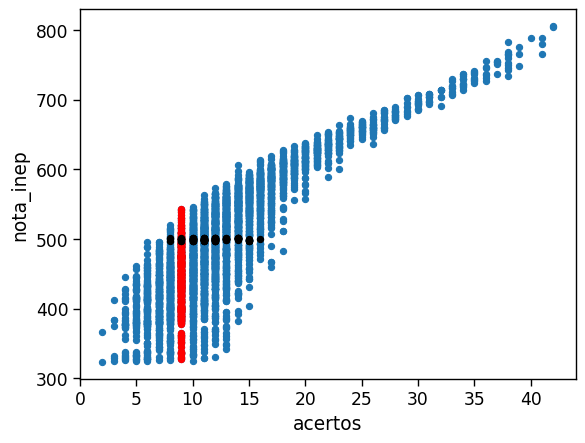

In [124]:
ano = 2023
area = 'CN'
df = load_acertos(ano,area,5000)
ax = df.plot(kind='scatter',x='acertos',y='nota_inep')
df.query("acertos == 9").plot(kind='scatter',x='acertos',y='nota_inep', color='r',ax=ax)
df.query("nota_inep > 497 & nota_inep < 502").plot(kind='scatter',x='acertos',y='nota_inep', color='k',ax=ax)

Vemos que para pessoas com 9 acertos a nota ENEM pode variar de 330 até 530, dependendo quais questões acertaram. E, para quem tirou uma nota ENEM de 500, o número de acertos pode ter sido entre 9 e 16.

## O "peso" da questão não é sua dificuldade

O que explica esta diferença é o padrão de respostas dos candidatos. De uma forma geral, quem acerta de forma mais consistente ganha uma nota maior. Mas, contrário ao senso comum, não é verdade que questões mais difíceis "pesam mais" e levam a uma nota maior. Talvez surpreendentemente, dado um certo número de acertos, é melhor acertar itens fáceis do que acertar itens difícil. Podemos mostrar isso com candidatos reais.

O INEP fornece os parâmetros dos itens, as características das questões determinadas durante o processo de testagem. O parâmetro $a$ representa a "discriminação" do item, $b$ é a dificuldade e $c$ a probabilidade de acerto por acaso. Mais abaixo explicamaremos melhor como interpretar estes parâmetros. Agora vamos mostrar que o parâmetro `b` *não* deve ser interpretado como o "peso" da questão. 

In [125]:
params = params_inep(ano, area)
params[:5]

,a_inep,b_inep,c_inep,u
CO_ITEM,,,,
64023,1.81,1.42,0.25,1
97149,0.99,1.56,0.20,1
84041,3.68,1.27,0.10,1
66259,2.34,1.00,0.24,1
117866,2.34,1.77,0.11,1


Com algumas manobras, podemos mostrar a diferença entre as padrões de resposta de dois candidatos com o mesmo número de acertos. Observe que a nota alta é obtida para quem acerto as questões mais fáceis. O padrão com acertos em itens difíceis mas erros em itens fáceis é pouco provável e o algoritmo TRI associa uma nota baixa. 

In [127]:
itens_a = pd.qcut(params['a_inep'],3,labels=['Baixa','Média','Alta'])
itens_b = pd.qcut(params['b_inep'],3,labels=['Baixa','Média','Alta'])
itens = pd.concat([itens_a,itens_b],axis=1)
itens.columns = ['discriminação','dificuldade']

def compare_padr(nacertos=9):
    padrmin = df.loc[df.query("acertos == @nacertos")['nota_inep'].idxmin()]
    padrmax = df.loc[df.query("acertos == @nacertos")['nota_inep'].idxmax()]
    notamin,notamax = padrmin['nota_inep'], padrmax['nota_inep']
    padrmin = padrmin[:-3]; padrmax = padrmax[:-3]
    padrmin.index = padrmin.index.astype(str);padrmax.index = padrmax.index.astype(str)
    result = params.join(itens).join(padrmin).join(padrmax)
    result.columns = ['a','b','c','u','discriminação','dificuldade','nota_baixa','nota_alta']
    result = result.sort_values(['b'],ascending=True).query("nota_baixa == 1 or nota_alta == 1")
    result.columns = ['a','b','c','u','discriminação','dificuldade',f'nota = {notamin}',f'nota = {notamax}']
    return result

iw = widgets.IntText(
    value=9,
    description='Acertos:',
)
interact(compare_padr, nacertos=iw);

interactive(children=(IntText(value=9, description='Acertos:'), Output()), _dom_classes=('widget-interact',))

Podemos também comparar dois candidatos com notas parecidas do ENEM. Vemos na figura acima que candidatos com uma nota de 500 podem ter acertado entre 6 e 15 itens. Qual é a diferença entre os padrões de resposta deste dois candidatos?

Veja abaixo como o padrão de resposta é diferente para dois candidatos com essencialmente a mesma nota ENEM. O primeiro, com poucos acertos, acertou quase todas as questões fáceis. O segundo também acertou uma fração das questões fáceis, mas errou alguns. Apesar de ter acertadas itens difíceis, não adiantou. Acertar uma questão difícil sem acertar as fáceis não leva a notas maiores no TRI. 

In [128]:
nota1, nota2 = 499,501
dfn = df.query("nota_inep <= @nota2 and nota_inep > @nota1")
padrmin = dfn.loc[dfn['acertos'].idxmin()]
padrmax = dfn.loc[dfn['acertos'].idxmax()]
notamin,notamax = padrmin['nota_inep'], padrmax['nota_inep']
acertosmin,acertosmax = padrmin['acertos'], padrmax['acertos']
padrmin = padrmin[:-3]; padrmax = padrmax[:-3]
padrmin.index = padrmin.index.astype(str);padrmax.index = padrmax.index.astype(str)
result = params.join(itens).join(padrmin).join(padrmax)
result.columns = ['a','b','c','u','discriminação','dificuldade','nota_baixa','nota_alta']
result = result.sort_values(['b'],ascending=True).query("nota_baixa == 1 or nota_alta == 1")
result.columns = ['a','b','c','u','discriminação','dificuldade',f'acertos: {acertosmin}, nota: {notamin}',f'acertos: {acertosmax}, nota = {notamax}']
result = result.drop(columns=['a','b','c','u'])
result

,discriminação,dificuldade,"acertos: 8.0, nota: 499.7","acertos: 16.0, nota = 499.7"
CO_ITEM,,,,
83378,Baixa,Baixa,1.00,0.00
40724,Baixa,Baixa,1.00,1.00
126604,Alta,Baixa,1.00,0.00
117887,Média,Baixa,0.00,1.00
117631,Baixa,Baixa,1.00,0.00
141723,Média,Baixa,1.00,1.00
83558,Baixa,Baixa,0.00,1.00
66259,Média,Baixa,0.00,1.00
111665,Alta,Baixa,0.00,1.00


## O modelo TRI determina a probabilidade dos padrões de resposta
A teoria de resposta ao item faz uma modelagem probabilística para as respostas de um candidato às questões da prova. Vamos chamar a habilidade (presuposto uma quantidade unidimensional nos modelos simples) $\theta$ e os padrões de resposta $x_i = 0$ (errou) ou $1$ (acertou) para $i=1\ldots 45$. Então o model TRI postula que um candidato com habilidade $\theta$ tem uma certa probabilidade $P_i(x_i = 1|\theta;a_i,b_i,c_i)$ que o candidato acertar a questão $i$. É esta "habilidade" $\theta$ que vai virar a nota do ENEM.

Vemos que a probabilidade de acertar depende da habilidade do candidato e das características das questões (parametrizado acima com três parâmetros, mas pode haver outros modelos para as características das questões). Qualquer modelo razoável vai dar uma probabilidade maior de acerto para habilidades $\theta$ maiores. Da mesma forma, a probabilidade de acerto deve diminuir para questões mais difíceis (para uma determinada habilidade fixa). Grande parte do problema técnica da TRI é estimar, baseado em muitas padrões de resposta a provas como estas que vimos acima, as características das questões. Por agora vamos supor que esta calibração das características das questões foi feito e que conhecemos os parâmetros das questões e portanto a função $P_i$. Agora vamos se perguntar: dado uma certa habilidade, quais serão as padrões de resposta mais prováveis? Uma vez que temos um modelo para esta pergunta, vamos inverter a questão e perguntar: dado um certo padrão de resposta, qual é a habilidade correspondente mais provável?

A probabilidade de um determinado padrão de respostas $\{x_1, x_2 \ldots x_{45}\} = \{x_i\} = \vec{x}$, dado uma certa habilidade é

$$ \text{prob}(\vec{x}|\theta)= \prod_{i=1}^{45} P_i(\theta)^{x_i} (1-P_i(\theta))^{1-x_{i}} $$

Isso parece uma expressão complicada, mas é possível de entender. Estamos supondo que as probabilidades de acertar questões são todas independentes. Neste caso, as leis da probabilidade dizem que precisamos multiplicar as probabilidades de acerto para todas as 45 questões da prova. Vamos supor que queremos saber a probabilidade de um determinado padrão de resposta, digamos $\{0,1,1,0\ldots\}$. A probabilidade de *errar* a primeira questão é $(1-P_1)$, a probabilidade de *acertar* a segunda questão é $P_2$, a terceira $P_3$, a de *errar* a quarta $(1-P_4)$, e assim até a última questão e precisamos multiplicar todas estas probabilidades. Observe que os expoentes $P_i^{x_1}$ na expressao acima é só notação que escolha $P$ para um acerto ($x_i = 1)$ e $(1-P)$ para um erro ($x_i = 0)$. 

A expressão acima para as $2^{45}$ probabilidades, um para cada padrão de respostas possível, é o *modelo* da TRI. Se não fixamos uma habilidade, cada probabilidade de cada padrão de resposta pode ser considerada uma função da habilidade $\theta$. Há duas formas de "inverter" a expressão acima se conhecemos o padrão de resposta mas agora queremos saber a habilidade $\theta$. Primeiro o método tradiconal em estastística, "máxima verossimilhança". Segundo, o método Bayesiano.


### Estimar $\theta$ por meio do método de máxima verossimilhança
Para demonstrar como a inferência da habilidade $\theta$ funciona, dado um padrão de respostas, vamos analisar um modelo concreto. Precisamos especificar as características das questões (as funções $P_i$) e como exemplo vamos analisar um dos $2^{45}$ padrões de resposta possível: 45 cinco respostas (acertos ou erros para cada uma das questões): $\{0,1,1,0\ldots\}$. 

Veja as probalidades de acerto que vamos usar (só vamos usar alguns, a título de exemplo):

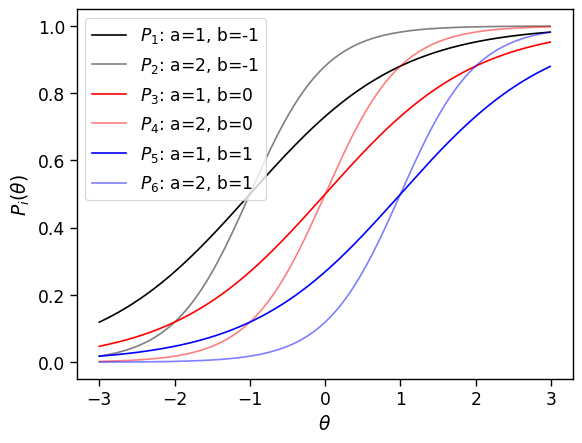

In [118]:
theta = np.arange(-3,3,0.01)
sns.set_context('paper',font_scale=1.4)
def P(theta,a=1,b=0,c=0):
    return c + (1-c)*1/(1+np.exp(a*(b-theta)))
colors = ['k','r','b'];i=0
for b in [-1,0,1]:
    for a in [1,2]:
        color = colors[i//2];i +=1
        alpha = 1/a
        sns.lineplot(x=theta,y=P(theta,a,b),color=color, alpha = alpha, label=f"$P_{i}$: a={a}, b={b}")
ax = plt.gca()
ax.set_xlabel(r"$\theta$");ax.set_ylabel(r"$P_i(\theta)$");

Vamos inicialmente imaginar que só temos informação sobre o acerto ou erro da primeira questão. No nosso exemplo, o candidato errou e $x_1 = 0$. Por enquanto, o nosso modelo diz:

$$ \text{prob}(x_1 = 0|\theta) = P_1(\theta)^{0} (1-P_1(\theta)^{1-0} = 1-P_1(\theta)$$


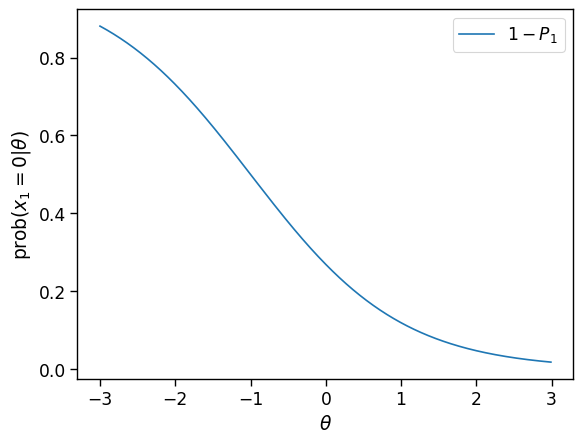

In [34]:
ax = sns.lineplot(x=theta,y=1-P(theta,a=1,b=-1), label=f"$1-P_{1}$");
ax.set_xlabel(r"$\theta$");ax.set_ylabel(r"$\mathrm{prob}(x_1=0|\theta)$");

Não dá, ainda, para dizer muito sobre a provável habilidade. No método de "máxima verossimilhança" ou ML, com somente a informação sobre o erro na primeira questão, a única coisa para dizer é que é mais provável que a habilidade é baixa. Veremos abaixo que no método Bayesiano, que leva em conta mais informação do que somente os acertos às questões, poderíamos dizer um pouco mais. Vamos à próxima questão, era um acerto: $x_2 =1$. Agora a probabilidade desta padrão de resposta é

$$\text{prob}(x_1 = 0, x_2 = 0|\theta) = (1-P_1(\theta))(P_2(\theta))$$

e podemos novamente fazer um gráfico da probabilidade desta "padrão de resposta" de agora duas respostas:

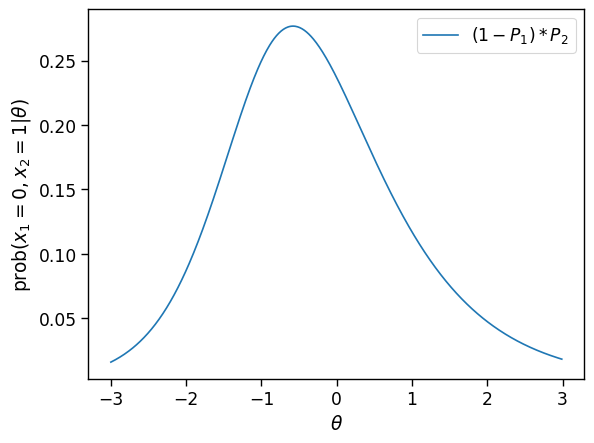

In [35]:
ax = sns.lineplot(x=theta,y=(1-P(theta,a=1,b=-1))*P(theta,a=2,b=-1), label=f"$(1-P_{1})*P_2$");
ax.set_xlabel(r"$\theta$");ax.set_ylabel(r"$\mathrm{prob}(x_1=0,x_2=1|\theta$)");

Vemos que com duas repostas, um erro e outro acerto, já podemos fazer inferências com um pouco mais de confiança. O método de "máxima verossimilhança" agora estima uma habilidade próximo de -1. Vamos, para finalizar o exemplo, analisar o padrão de resposta $\{0,1,1,0\}$. 

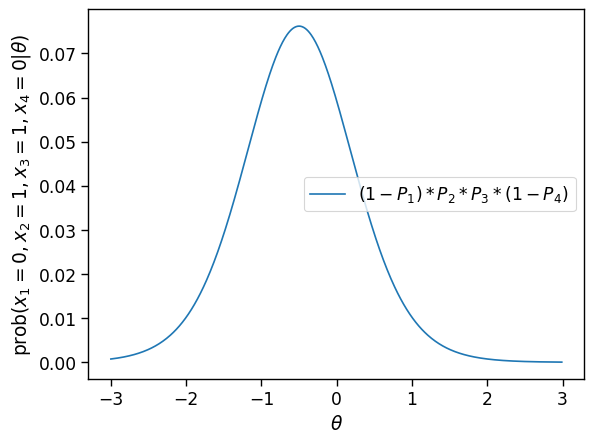

In [36]:
ax = sns.lineplot(x=theta,y=(1-P(theta,a=1,b=-1))*P(theta,a=2,b=-1)*P(theta,a=1,b=0)*(1-P(theta,a=2,b=0)), label=f"$(1-P_{1})*P_2*P_3*(1-P_4)$");
ax.set_xlabel(r"$\theta$");ax.set_ylabel(r"$\mathrm{prob}(x_1=0,x_2=1,x_3=1,x_4=0|\theta$)");

Podemos concluir 


### Estimar $\theta$ por métodos Bayesianos
XXX

In [114]:
areawidg = widgets.Dropdown(
    options=['CN','CH','MT'],
    value='CN',
    description='Area:',
)
anowidg = widgets.Dropdown(
    options=range(2023,2008,-1),
    value=2022,
    description='Ano:',
)
faixawdg = widgets.BoundedFloatText(
    value=1,
    min=-1.2,
    max=3,
    step=0.1,
    description='Nota:',
    disabled=False
)

def escolhe_padr(ano=2022,area='CN',faixa=0):
    padr = load_acertos(ano,area,3000,True)
    nota = 500+faixa*100
    nota_inep = padr.iloc[:,-3:]
    nota_inep = nota_inep.query("nota_inep > @nota and nota_inep < @nota + 5")
    nota_inep = nota_inep.sample(1)
    nota = nota_inep['nota_inep'].iloc[0];acertos = nota_inep['acertos'].iloc[0]
    print(f"Acertos = {acertos}, nota INEP = {nota}" )
    index = nota_inep.index[0]
    padr = padr.loc[index:index]
    params = params_inep(ano,area,dropna=True)
    score_mirt_ml = score_inep(padr,ano,area,method="ML",enemscale=False)
    nota_mirt_ml = score_mirt_ml['nota'].iloc[0]
    se_mirt_ml = score_mirt_ml['se'].iloc[0]
    score_mirt_eap = score_inep(padr,ano,area,method="EAP",enemscale=False)
    nota_mirt_eap = score_mirt_eap['nota'].iloc[0]
    se_mirt_eap = score_mirt_eap['se'].iloc[0]

    print(f"Nota ML do mirt = {nota_mirt_ml:.2f} ± {se_mirt_ml:.2f}")
    print(f"Nota EAP do mirt = {nota_mirt_eap:.2f} ± {se_mirt_eap:.2f}")
    params = params.join(padr.T)
    return params

interact(escolhe_padr,ano=anowidg,area=areawidg,faixa=faixawdg)


interactive(children=(Dropdown(description='Ano:', index=1, options=(2023, 2022, 2021, 2020, 2019, 2018, 2017,…

<function __main__.escolhe_padr(ano=2022, area='CN', faixa=0)>

In [121]:

def vero(ano=2022,area='CN',faixa=0,ordem_dificuldade=True,calculate_until=45):

    params = escolhe_padr(ano,area,faixa=faixa)
    params = params.sort_values('b_inep',ascending=ordem_dificuldade)
    i=0

    theta = np.arange(-3,3,0.01)
    lh = np.ones(len(theta))
    
    for item,value in params.iterrows():
    
        if i == calculate_until: 
            print(f"stopped at item {i}")
            break
        i += 1
    
        acertou = int(value.iloc[-1])
        if acertou:
            lh = lh*P(theta,a=value['a_inep'],b=value['b_inep'],c=value['c_inep'])
        else:
            lh = lh*(1-P(theta,a=value['a_inep'],b=value['b_inep'],c=value['c_inep']))

    nota_ml = (-3+lh.argmax()*0.01)
    posterior = lh*norm.pdf(theta)
    nota_eap = np.average(theta, weights=posterior)
    def check(s):
        if s: return '✅'
        else: return '❌'
    params.iloc[:,-1] = params.iloc[:,-1].apply(check)
    params = params.drop(columns=['a_inep','u','c_inep'])
    params = params.transpose()
    params.insert(i,column = '🛑',value=['|>','|>'])
    pd.options.display.float_format = '{:.2f}'.format
    pd.set_option('display.max_columns', 500)
    display(params)
    with sns.axes_style("whitegrid"):
        fig,axs = plt.subplots(1,2,sharex=True,figsize = (16,6))
        ax1 = axs[0]; ax2 = axs[1]
        sns.lineplot(x=theta,y=lh,ax=ax1);
        ax1.set_xlabel(r"$\theta$");ax.set_ylabel(r"$\mathrm{prob}(\vec{x_i}|\theta)$");
        ax1.set_title(f"Máxima verossimilhança: nota = {nota_ml:.3f}");
        sns.lineplot(x=theta,y=posterior,ax=ax2);
        ax2.set_xlabel(r"$\theta$");ax.set_ylabel(r"Posterior");
        ax2.set_title(f"Expected a Posteriori: nota = {nota_eap:.3f}");
        
        plt.grid(axis='y')
    return


interact(vero,ordem_dificuldade=True,calculate_until=range(0,46))

interactive(children=(IntSlider(value=2022, description='ano', max=6066, min=-2022), Text(value='CN', descript…

<function __main__.vero(ano=2022, area='CN', faixa=0, ordem_dificuldade=True, calculate_until=45)>